## Figure 3 plot

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from skbio.stats.distance import anosim
from skbio.stats.distance import permanova
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import pandas.util.testing as pdt
from statannot import add_stat_annotation


/Users/xiaoqiong/opt/anaconda3/envs/meta/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  del sys.path[0]


In [2]:
## Figure 3A - PCoA analysis
asv_rel = pd.read_csv('data/asv-rel.csv', index_col=0)

def pcoa_step1(df):
    y = scipy.spatial.distance.pdist(df.T, metric='braycurtis')
    dm = scipy.spatial.distance.squareform(y)
    dm = pd.DataFrame(dm)
    pcoa_seq = pcoa(dm)
    pc1 = pcoa_seq.proportion_explained[0]
    pc2 = pcoa_seq.proportion_explained[1]
    pcoaPC12 = pcoa_seq.samples.iloc[:, 0:3]
    samplename = df.columns
    pcoaPC12.index = samplename
    pcoaPC12.reset_index(level=0, inplace=True)

    AAD = ['S2', 'S10', 'S15', 'S16', 'S24', 'S1',
           'S5', 'S6', 'S7', 'S13', 'S19', 'S20', 'S21']
    
    pcoaPC12['Group'] = pcoaPC12['index'].apply(lambda x: 'AAD' if x.split('D')[0] in AAD else 'non-AAD')
    pcoaPC12['Day'] = pcoaPC12['index'].apply(lambda x: int(x.split('D')[1]))
    
    return pcoaPC12

In [3]:
asv_filter = asv_rel.filter(regex="D0$|D3$|D7$|D28$")
filtered_pcoa = pcoa_step1(asv_filter)
filtered_pcoa['Day3'] = filtered_pcoa['Day'].apply(
    lambda x: 'D3' if x == 3 else 'non-D3')
filtered_pcoa

/Users/xiaoqiong/opt/anaconda3/envs/meta/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.12114676383298252 and the largest is 3.530034247149693.
  RuntimeWarning
/Users/xiaoqiong/opt/anaconda3/envs/meta/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/xiaoqiong/opt/anaconda3/envs/meta/lib/python3.6/s

,index,PC1,PC2,PC3,Group,Day,Day3
0,S1D0,0.145098,-0.145676,-0.231988,AAD,0,non-D3
1,S1D3,-0.314196,-0.386313,-0.026769,AAD,3,D3
2,S1D7,-0.037919,-0.237326,-0.301406,AAD,7,non-D3
3,S1D28,0.081393,-0.195699,-0.394329,AAD,28,non-D3
4,S2D0,0.053267,-0.171784,-0.404500,AAD,0,non-D3
...,...,...,...,...,...,...,...
110,S31D7,0.147567,0.095132,0.067238,non-AAD,7,non-D3
111,S31D28,0.197273,-0.041682,-0.105169,non-AAD,28,non-D3
112,S33D0,-0.033852,0.205266,0.051253,non-AAD,0,non-D3
113,S33D3,-0.142630,0.151044,-0.018231,non-AAD,3,D3


In [4]:
# print the first and second dimension - variability x% y%
y = scipy.spatial.distance.pdist(asv_filter.T, metric='braycurtis')
dm = scipy.spatial.distance.squareform(y)
dm = pd.DataFrame(dm)
pcoa_seq = pcoa(dm)
print(pcoa_seq.proportion_explained[:3])

PC1    0.163321
PC2    0.104035
PC3    0.090494
dtype: float64


/Users/xiaoqiong/opt/anaconda3/envs/meta/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.12114676383298252 and the largest is 3.530034247149693.
  RuntimeWarning


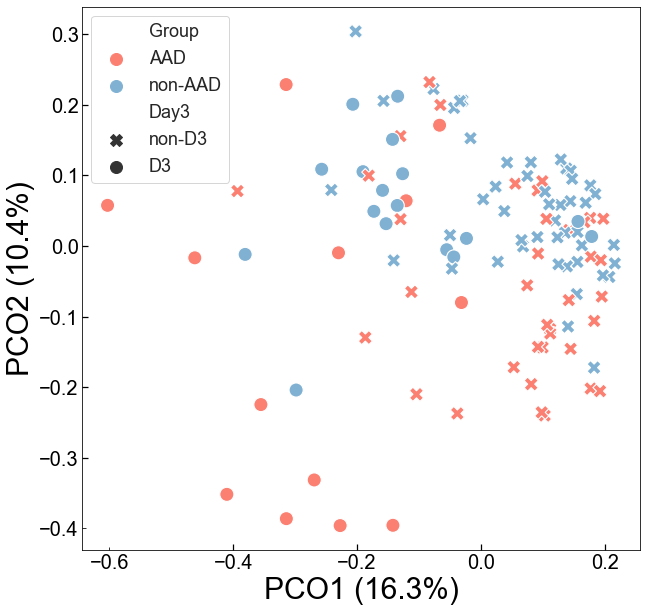

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.set(style='white', color_codes=True, font='Arial')

markers = {"non-D3": "X", "D3": "o"}
ax = sns.scatterplot(x="PC1", y="PC2", data=filtered_pcoa, hue='Group',
                     style='Day3', s=200, palette=['#fb8072', '#80b1d3'], markers=markers)

ax.set_xlabel('PCO1 (16.3%)', fontsize=30)  # variable X
ax.set_ylabel('PCO2 (10.4%)', fontsize=30)  # variable Y
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()

ax.tick_params(axis='both', labelsize=20, direction="in")
plt.legend(fontsize=18, markerscale=2)
plt.savefig('plots/Figure3A_pcoa.svg', dpi=300)

In [6]:
## Figure 3B.a - alpha and beta diversity analysis

# define AAD group
## AAD: S2, S10, S15, S16, S24, S1, S5-S7, S19-S21, S13 => 13 AAD vs 17 non-AAD
AAD_list = ['S2', 'S10', 'S15', 'S16', 'S24', 'S1',
            'S5', 'S6', 'S7', 'S13', 'S19', 'S20', 'S21']


adiv = pd.read_csv('data/alpha_div.tsv', sep='\t', index_col=0)
adiv['Group'] = adiv.index.to_series().apply(
    lambda x: 'AAD' if x.split('D')[0] in AAD_list else 'non-AAD')
adiv['Day_order'] = adiv.index
adiv['day_oder'] = ['D' + x.split('D')[1] for x in adiv['Day_order']]


JSD = pd.read_csv('data/JSD.csv', index_col=0)
JSD = JSD.reset_index()
JSD_long = JSD.melt(id_vars=['Subject'], value_vars=[
                          'D1', 'D2', 'D3', 'D7', 'D14', 'D28'], value_name='JSD')
JSD_long['Group'] = JSD_long['Subject'].apply(
    lambda x: 'AAD' if x in AAD_list else 'non-AAD')
JSD_long.columns = ['Subject', 'Day_order', 'JSD', 'Group']


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

D1_AAD v.s. D1_non-AAD: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.320e-02 U_stat=3.800e+01
D0_AAD v.s. D0_non-AAD: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.858e-01 U_stat=5.700e+01
D2_AAD v.s. D2_non-AAD: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.514e-02 U_stat=3.200e+01
D3_AAD v.s. D3_non-AAD: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.477e-02 U_stat=4.900e+01
D7_AAD v.s. D7_non-AAD: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.682e-01 U_stat=5.900e+01
D14_AAD v.s. D14_non-AAD: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.290e-02 U_stat=3.700e+01
D28_AAD v.s. D28_non-AAD: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000

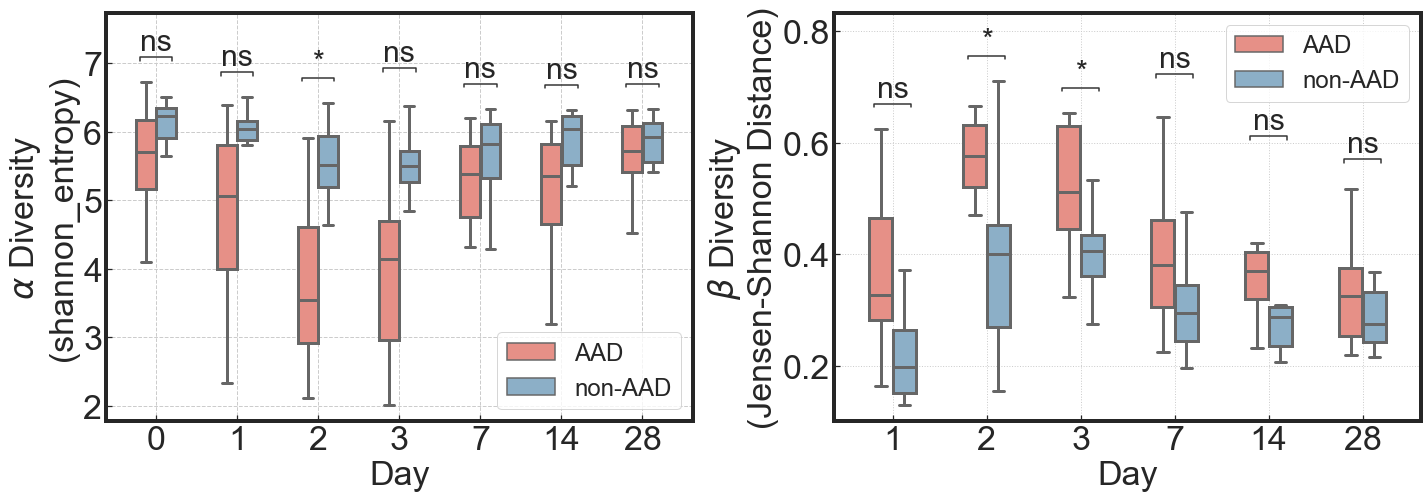

In [7]:
### combine the two figures

Day_order = ['D0',"D1","D2","D3","D7","D14","D28"]
fig, ax = plt.subplots(1,2,figsize=(20, 7))

sns.set(style='white',color_codes=True, font='Arial')
sns.boxplot(x="day_oder",y="shannon_entropy",hue="Group",data=adiv,width=0.5,order=Day_order,saturation=0.7,palette=['#fb8072','#80b1d3'],showfliers=False,ax=ax[0],linewidth=3)

ax[0].set_xlabel('Day',fontsize=34)
ax[0].set_ylabel(r'$\alpha$ Diversity'+'\n(shannon_entropy)',fontsize=34)

ax[0].grid(axis='both', which='major', ls='--')

ax[0].yaxis.tick_left()
ax[0].xaxis.tick_bottom()
ax[0].tick_params(axis='both',direction="in",labelsize=34)#length=12, width=2

ax[0].legend().set_title('')
ax[0].legend(fontsize=24)
ax[0].set_xticklabels(['0','1','2','3','7','14','28'])

box_pairs = [
    (('D0','AAD'),('D0','non-AAD')),
    (('D1','AAD'),('D1','non-AAD')),
    (('D2','AAD'),('D2','non-AAD')),
    (('D3','AAD'),('D3','non-AAD')),
    (('D7','AAD'),('D7','non-AAD')),
    (('D14','AAD'),('D14','non-AAD')),
    (('D28','AAD'),('D28','non-AAD')),
] 
add_stat_annotation(ax[0], data=adiv, x='day_oder', y='shannon_entropy',line_height=0.01,hue='Group',order=Day_order,box_pairs = box_pairs, test='Mann-Whitney', text_format='star', loc='inside', verbose=2,fontsize=30)

Day_order = ["D1","D2","D3","D7","D14","D28"]

ax[1] = sns.boxplot(x="Day_order",y="JSD",hue="Group",data=JSD_long,width=0.5,order=Day_order,saturation=0.7,palette=['#fb8072','#80b1d3'],showfliers=False,linewidth=3)
ax[1].set_xlabel('Day',fontsize=34)
ax[1].set_ylabel(r'$\beta$ Diversity'+'\n(Jensen-Shannon Distance)',fontsize=34)

ax[1].grid(which='major', axis='both',linestyle='dotted')

ax[1].yaxis.tick_left()
ax[1].xaxis.tick_bottom()
ax[1].tick_params(axis='both',direction="in",labelsize=34)#length=10, width=1

ax[1].legend().set_title('')
ax[1].legend(fontsize=24)
ax[1].set_xticklabels(['1','2','3','7','14','28'])

box_pairs = [
    (('D1','AAD'),('D1','non-AAD')),
    (('D2','AAD'),('D2','non-AAD')),
    (('D3','AAD'),('D3','non-AAD')),
    (('D7','AAD'),('D7','non-AAD')),
    (('D14','AAD'),('D14','non-AAD')),
    (('D28','AAD'),('D28','non-AAD')),
] 
add_stat_annotation(ax[1], data=JSD_long, x='Day_order', y='JSD',line_height=0.01,hue='Group',order=Day_order,box_pairs = box_pairs, test='Mann-Whitney', text_format='star', loc='inside', verbose=2,fontsize=30)

plt.tight_layout()

for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(4)  
    ax[1].spines[axis].set_linewidth(4)

plt.savefig('plots/Figure3B_diversity.svg',dpi=300)

In [8]:
## Figure 3C - Taxonomy analysis

asv_rel_p = pd.read_csv('data/asv-level-2-rel.csv', index_col=0)

# define AAD group
## AAD: S2, S10, S15, S16, S24, S1, S5-S7, S19-S21, S13 => 13 AAD vs 17 non-AAD

def AAD(df):
    AAD = df.filter(
        regex="S2D|S10D|S15|S16|S24|S1D|S5D|S6D|S7D|S13D|S19|S20|S21")
    return AAD

def non(df):
    non = df.filter(
        regex="S3D|S4D|S8D|S9D|S11D|S12D|S14|S17|S22|S23|S25|S26|S27|S29|S30|S31|S33")
    return non
    
def top(df, N):
    '''this function is used to pick up the top N level form the dataframe'''
    top = df.sum(axis=1).sort_values(ascending=False)[:N].index
    return top

def avg_df(df):
    df_avg = pd.DataFrame(data=None)
    df_avg['D0'] = df.filter(regex="D0$").mean(axis=1)
    df_avg['D1'] = df.filter(regex="D1$").mean(axis=1)
    df_avg['D2'] = df.filter(regex="D2$").mean(axis=1)
    df_avg['D3'] = df.filter(regex="D3$").mean(axis=1)
    df_avg['D7'] = df.filter(regex="D7$").mean(axis=1)
    df_avg['D14'] = df.filter(regex="D14$").mean(axis=1)
    df_avg['D28'] = df.filter(regex="D28$").mean(axis=1)
    return df_avg


In [9]:
asv_rel_p_AAD_avg = avg_df(AAD(asv_rel_p.loc[top(asv_rel_p, 4)]))
asv_rel_p_non_avg = avg_df(non(asv_rel_p.loc[top(asv_rel_p, 4)]))


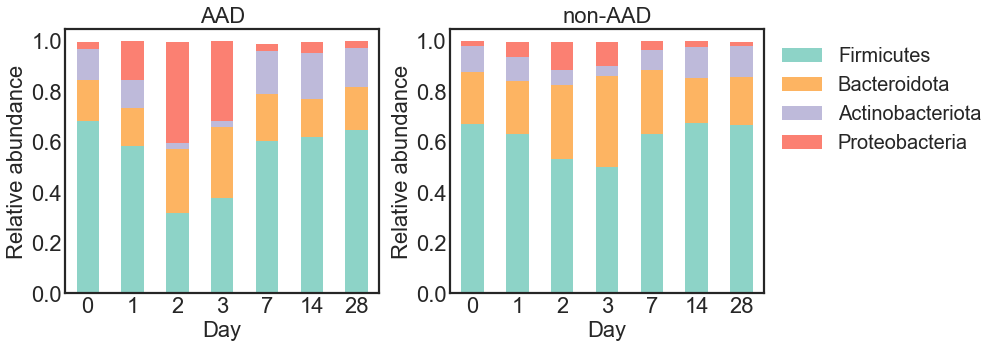

In [10]:
colorcodes = ['#8dd3c7', '#fdb462', '#bebada', '#fb8072',
              '#80b1d3', '#ffed6f',  '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd']
sns.set_palette(sns.color_palette(colorcodes))
sns.color_palette()

plt.style.use('seaborn-white')
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 5))
asv_rel_p_AAD_avg.T.plot(kind='bar', stacked=True,
                           linewidth=0, ax=ax0)  # colormap='Set2'
asv_rel_p_non_avg.T.plot(kind='bar', stacked=True, linewidth=0, ax=ax1)
ax1.get_legend().remove()
ax0.get_legend().remove()
fontsize = 22
ax0.set_title('AAD', size=fontsize)
ax1.set_title('non-AAD', size=fontsize)

ax0.yaxis.tick_left()
ax1.yaxis.tick_left()
ax0.tick_params(axis='both', labelsize=fontsize, direction="in")
ax1.tick_params(axis='both', labelsize=fontsize, direction="in")

# revise the x,y tick label
ax0.set_xticklabels(['0', '1', '2', '3', '7', '14', '28'], rotation=0)
ax1.set_xticklabels(['0', '1', '2', '3', '7', '14', '28'], rotation=0)
ax0.set_xlabel('Day', size=fontsize)
ax1.set_xlabel('Day', size=fontsize)
ax0.set_ylabel('Relative abundance', size=fontsize)
ax1.set_ylabel('Relative abundance', size=fontsize)

# revise the legend
handles, labels = ax0.get_legend_handles_labels()
labels2 = [x.split(';')[-1].split('__')[-1] for x in labels]

ax1.legend(handles, labels2, loc="best",  fontsize=20, bbox_to_anchor=(1, 1))

for axis in ['top', 'bottom', 'left', 'right']:
  ax0.spines[axis].set_linewidth(2.2)
  ax1.spines[axis].set_linewidth(2.2)

plt.tight_layout()
plt.savefig('plots/Figure3C_AAD_non_top4p.svg', dpi=300)
